In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import seaborn as sns
from thesispy.definitions import ROOT_DIR

INSTANCES_PATH = Path('/home/joasiee/Documents/instances/synthetic/scans/')

In [373]:
def generate_sphere(x, y, z, radius, center):
    return (x - center[0] + 0.5)**2 + (y - center[1] + 0.5)**2 + (z - center[2] + 0.5)**2 < radius**2

def generate_cube(dims, low, high, val=100):
    cube = np.zeros(dims)
    cube[low:high, low:high, low:high] = val
    return cube    

def map_sphere(p, radius, center, new_radius):
    p = np.array(p)
    center = np.array(center)
    if np.all(p == center):
        return p
    
    p = (p - center) / radius
    p = p * new_radius
    return p + center

def map_fixed_point_in_moving_sphere(p, center, r_sphere_f, r_sphere_m, r_sq):
    p = np.array(p)
    center = np.array(center)
    p_norm = p - center
    u = np.max(np.abs(p_norm))
    
    p_sq = r_sq * (p_norm / u) + center
    p_sphere_m = r_sphere_m / np.linalg.norm(p_norm) * p_norm + center
    p_sphere_f = r_sphere_f / np.linalg.norm(p_norm) * p_norm + center
    d1 = np.linalg.norm(p - p_sphere_f)
    d2 = np.linalg.norm(p_sphere_f - p_sphere_m)
    return p_sphere_m + d1/d2 * (p_sq - p_sphere_m)

def generate_synthetic_01():
    fixed = generate_cube((30, 30, 30), 5, 25)
    fixed_sphere = generate_sphere(*np.indices(fixed.shape), 5, (15, 15, 15))
    fixed[fixed_sphere > 0] = 200

    moving = generate_cube((30, 30, 30), 5, 25)
    moving_sphere = generate_sphere(*np.indices(moving.shape), 8, (15, 15, 15))
    moving[moving_sphere > 0] = 200

    dvf = np.zeros((30, 30, 30, 3), dtype=np.float32)
    for p in np.ndindex((30, 30, 30)):
        p_pixel = np.array(p) + 0.5
        if fixed_sphere[p] > 0:
            dvf[p] = map_sphere(p_pixel, 5, (15, 15, 15), 8) - p_pixel

            # pixel rounding error fix by moving point 1 pixel back in opposite direction
            mapped_pos = tuple(np.round(p_pixel + dvf[p] - 0.5).astype(int))
            if moving_sphere[mapped_pos] == 0:
                dir = np.sign(dvf[p])*-1
                dvf[p] = dvf[p] + dir * 0.5

        elif moving_sphere[p] > 0:
            dvf[p] = map_fixed_point_in_moving_sphere(p_pixel, (15, 15, 15), 5, 8, 10) - p_pixel

        pos = p_pixel + dvf[p]
        dir = np.sign(dvf[p])
        for dim in range(len(pos)):
            if dir[dim] < 0:
                pos[dim] = np.floor(pos[dim]) + 0.5
            else:
                pos[dim] = np.ceil(pos[dim]) - 0.5
        dvf[p] = pos - p_pixel
        
    return fixed, moving, dvf

In [374]:
def get_img_data(path: Path):
    image = sitk.ReadImage(str(path.resolve()))
    data = sitk.GetArrayFromImage(image)
    if len(data.shape) == 4 or (len(data.shape) == 3 and data.shape[-1] > 2):
        data = np.swapaxes(data, 0, 2)
    else:
        data = np.swapaxes(data, 0, 1)

    return data

def get_cmap_color(cmap, f, a):
    c = cmap(f)
    c[..., 3] = a
    return c

def plot_voxels(data, y_slice_depth = 15, orientation=(0, -70), cmap_name='Greys', alpha=1.0):
    ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
    sliced_data = np.copy(data)
    sliced_data[:, :y_slice_depth, :] = 0
    
    cmap = cm.get_cmap(cmap_name)
    norm = Normalize(vmin=np.min(sliced_data), vmax=1.5*np.max(sliced_data))

    colors = np.array(list(map(lambda x: get_cmap_color(cmap, norm(x), alpha), sliced_data)))

    ax.voxels(sliced_data, facecolors=colors, edgecolor=(0, 0, 0, 0.2))
    ax.set_xlim3d(1, 29)
    ax.set_ylim3d(5, 29)
    ax.set_zlim3d(1, 29)
    ax.set_box_aspect((np.ptp(ax.get_xlim()), np.ptp(ax.get_ylim()), np.ptp(ax.get_zlim())))
    plt.locator_params(axis='y', nbins=3)
    ax.view_init(*orientation)

def plot_dvf(data, scale=None, invert=False, slice=None):
    if len(data.shape[:-1]) > 2:
        if slice is None:
            slice = data.shape[0] // 2
        data = data[:,:,slice,:]
    
    X, Y = np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1]))
    if invert:
        X = X + data[..., 1]
        Y = Y + data[..., 0]
        data = -data

    X = X + 0.5
    Y = Y + 0.5

    u = data[:,:,0]
    v = data[:,:,1]
    c = np.sqrt(u**2 + v**2)
    
    fig, ax = plt.subplots(figsize =(7, 7))
    qq = ax.quiver(X, Y, v, u, c, scale=scale, units='xy', angles='xy', scale_units='xy', cmap=plt.cm.Greys)

    # ax.axis('off')
    ax.set_xticks([i for i in range(data.shape[0])][::2])
    ax.set_yticks([i for i in range(data.shape[1])][::2])
    ax.set_xlim(0, data.shape[0])
    ax.set_ylim(0, data.shape[1])
    ax.grid(True)
    ax.set_aspect('equal')
    fig.colorbar(qq,fraction=0.045, pad=0.02, label='Displacement magnitude')
    plt.show()

In [375]:
from joblib import Parallel, delayed
from tqdm import tqdm

class ProgressParallel(Parallel):
    def __init__(self, use_tqdm=True, total=None, *args, **kwargs):
        self._use_tqdm = use_tqdm
        self._total = total
        super().__init__(*args, **kwargs)

    def __call__(self, *args, **kwargs):
        with tqdm(disable=not self._use_tqdm, total=self._total) as self._pbar:
            return Parallel.__call__(self, *args, **kwargs)

    def print_progress(self):
        if self._total is None:
            self._pbar.total = self.n_dispatched_tasks
        self._pbar.n = self.n_completed_tasks
        self._pbar.refresh()

def hessian(dvf_slice, p):
  p = np.array(p, dtype=int)
  try:
    dvf_slice[tuple(p)]
  except IndexError:
    print(f"Point {p} is out of bounds")
    return None

  n = len(p)
  output = np.matrix(np.zeros(n*n))
  output = output.reshape(n,n)
  max_indices = np.array(dvf_slice.shape) - 1
  ei = np.zeros(n, dtype=int)
  ej = np.zeros(n, dtype=int)
  
  for i in range(n):
    for j in range(i+1):
      ei[i] = 1
      ej[j] = 1
      f1 = dvf_slice[tuple((np.clip(p + ei + ej, 0, max_indices)))]
      f2 = dvf_slice[tuple((np.clip(p + ei - ej, 0, max_indices)))]
      f3 = dvf_slice[tuple((np.clip(p - ei + ej, 0, max_indices)))]
      f4 = dvf_slice[tuple((np.clip(p - ei - ej, 0, max_indices)))]
      numdiff = (f1-f2-f3+f4)/4     
      output[i,j] = numdiff
      output[j,i] = numdiff
      ei[i] = 0
      ej[j] = 0
  return output

def bending_energy_point(dvf, p):
  sum = 0.0
  for dim in range(len(dvf.shape)-1):
    sum += np.square(np.linalg.norm(hessian(dvf[..., dim], p)))
  return sum

def bending_energy(dvf):
  results = ProgressParallel(n_jobs=16, total=np.prod(dvf.shape[:-1]))(delayed(bending_energy_point)(dvf, p) for p in np.ndindex(dvf.shape[:-1]))

  return np.sum(results) / np.prod(dvf.shape[:-1])

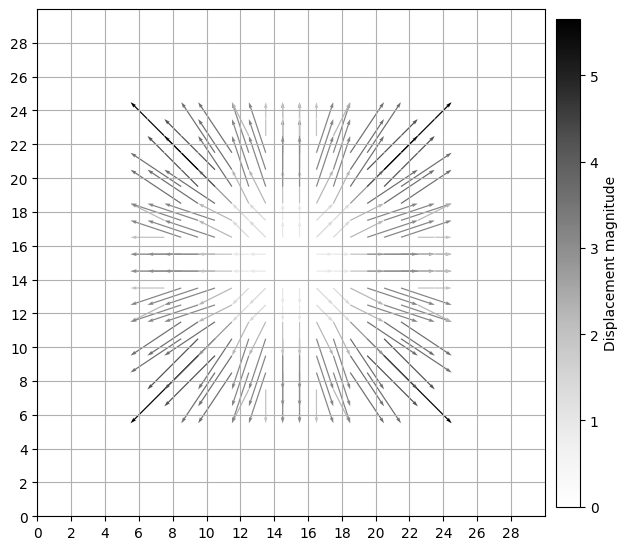

In [376]:
fixed, moving, dvf = generate_synthetic_01()
plot_dvf(dvf, scale=1)

In [377]:
import SimpleITK as sitk
from ipywidgets import interact, fixed

In [378]:
fixed, moving, dvf = generate_synthetic_01()
dvf = np.swapaxes(dvf, 0, 2)

displacement = sitk.DisplacementFieldTransform(3)
field_size = [30, 30, 30]
field_origin = [0, 0, 0]
field_spacing = [1, 1, 1]
field_direction = [1, 0, 0, 0, 1, 0, 0, 0, 1]
displacement.SetFixedParameters(field_size + field_origin + field_spacing + field_direction)
displacement.SetInterpolator(sitk.sitkLinear)
displacement.SetDisplacementField(sitk.GetImageFromArray(dvf.astype(np.float64)))

fixed_img = sitk.ReadImage("/home/joasiee/Documents/instances/synthetic/scans/01_Fixed.mhd")
moving_img = sitk.ReadImage("/home/joasiee/Documents/instances/synthetic/scans/01_Moving.mhd")
deformed_img = sitk.Resample(moving_img, fixed_img, displacement, sitk.sitkLinear, 0.0)


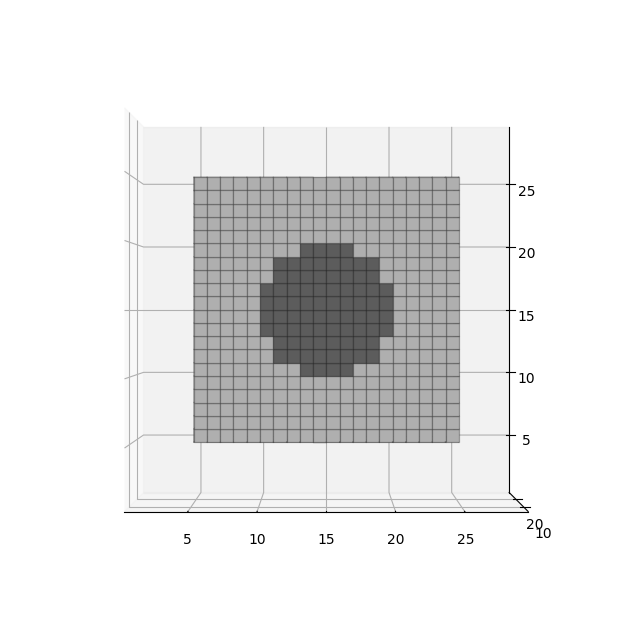

In [379]:
deformed_img_np = sitk.GetArrayFromImage(deformed_img)
deformed_img_np = np.swapaxes(deformed_img_np, 0, 2)
plot_voxels(deformed_img_np, y_slice_depth=15, orientation=(0, -90))

In [380]:
np.sum(deformed_img_np - fixed)

0.0

In [198]:
# # Bending energy calculation using interpolation

# from joblib import Parallel, delayed
# import numdifftools as nd
# from interp3d import interp_3d
# from tqdm import tqdm

# def get_hessians_numdiff(dvf):
#   hessians = []
#   for dim in range(len(dvf.shape)-1):
#       dvf_slice = dvf[..., dim]
#       max_indices = np.array(dvf_slice.shape) - 1
#       dvf_mapping = lambda x: dvf_slice[tuple(np.clip(x.astype(int), 0, max_indices))]
#       hessian = nd.Hessian(dvf_mapping, step=1)
#       hessians.append(hessian)
#   return hessians

# def bending_energy_numdiff(dvf):
#   sum = 0.0
#   hessians = get_hessians_numdiff(dvf)
#   for p in np.ndindex(dvf.shape[:-1]):
#     for dim in range(len(dvf.shape)-1):
#       sum += np.square(np.linalg.norm(hessians[dim](p)))
#   return sum / np.prod(dvf.shape[:-1])

# def hessian(grid_interpolator, p, delta):
#   p = np.array(p)
#   try:
#     grid_interpolator(p)
#   except ValueError:
#     print(f"Point {p} is out of bounds")
#     return None

#   n = len(p)
#   output = np.matrix(np.zeros(n*n))
#   output = output.reshape(n,n)
#   max_indices = [grid_interpolator.max_x, grid_interpolator.max_y, grid_interpolator.max_z]
  
#   for i in range(n):
#     for j in range(i+1):
#       ei = np.zeros(n)
#       ei[i] = 1
#       ej = np.zeros(n)
#       ej[j] = 1
#       f1 = grid_interpolator(np.clip(p + delta * ei + delta * ej, 0, max_indices))
#       f2 = grid_interpolator(np.clip(p + delta * ei - delta * ej, 0, max_indices))
#       f3 = grid_interpolator(np.clip(p - delta * ei + delta * ej, 0, max_indices))
#       f4 = grid_interpolator(np.clip(p - delta * ei - delta * ej, 0, max_indices))
#       numdiff = (f1-f2-f3+f4)/(4*delta*delta)
#       output[i,j] = numdiff
#       output[j,i] = numdiff
#   return output

# def bending_energy_point(interpolator, p, delta):
#   return np.square(np.linalg.norm(hessian(interpolator, p, delta)))

# def bending_energy(dvf, delta=0.333):
#   n = np.prod(dvf.shape[:-1])

#   x = np.arange(dvf.shape[0])
#   y = np.arange(dvf.shape[1])
#   z = np.arange(dvf.shape[2])
#   sum = 0.0

#   for dim in range(len(dvf.shape)-1):
#     dvf_slice = np.copy(dvf[..., dim], order='C').astype(np.float64)
#     fn = interp_3d.Interp3D(dvf_slice, x,y,z)
#     results = ProgressParallel(n_jobs=16, total=n)(delayed(bending_energy_point)(fn, p, delta) for p in np.ndindex(dvf.shape[:-1]))
#     sum += np.sum(results)

#   return sum / np.prod(dvf.shape[:-1])